# Alias Analysis

#### Problem Definition
*  Reference :  Program Analysis and Specialization for C Programming Lang by Lars Ole Andersen 1994

* analysis tries to statically disambiguate memory references in the program so that the compiler can get a knowledge on which instructions might access the same memory location

* Classification Criteria 
    + flow-sensitive vs. flow-insensitive
    + context-sensitive vs. context-insensitive
    + field-sensitive vs. field-insensitive
    + unification-based vs. subset-based,
* Given Two Pointers, Conclude if they  MustAlias, MayAlias or MayNotAlias

### 1. BasicAA
*  aggressive local analysis from facts:
    + Distinct globals, stack allocations, and heap allocations can never alias.
    + Globals, stack allocations, and heap allocations never alias the null pointer.
    + Different fields of a structure do not alias.
    + Indexes into arrays with statically differing subscripts cannot alias.
    + Many common standard C library functions never access memory or only read memory.
    + Pointers that obviously point to constant globals “pointToConstantMemory”.
    + Function calls can not modify or references stack allocations if they never escape from the function that allocates them


```llvm
@s = global i8 1, align 1
@d = global i8 2, align 1
define void @test_alloca_argmemonly(i8* %s, i8* %d) {
entry:
  %a = alloca i8, align 1
  store i8 1, i8* %a, align 1
  call void @my_memcpy(i8* %d, i8* %s, i64 1)
  ret void
}

define i8 @test_readonly_arg(i8* noalias %s, i8* noalias %d) {
entry:
  call void @my_memcpy(i8* %d, i8* %s, i64 1)
  %ret = load i8, i8* %s, align 1
  ret i8 %ret
}
define void @test_noalias_argmemonly(i8* noalias %a, i8* %s, i8* %d) {
entry:
  store i8 1, i8* %a, align 1
  call void @my_memmove(i8* %d, i8* %s, i64 1)
  ret void
}

define void @test5(i8* noalias %a, i8* noalias %b) {
entry:
  store i8 1, i8* %a, align 1
  call void @my_memcpy(i8* %b, i8* %a, i64 1)
  store i8 1, i8* %b, align 1
  ret void
}

define void @test_argcollapse(i8* noalias %a, i8* noalias %b) {
entry:
  store i8 1, i8* %a, align 1
  call void @my_memmove(i8* %b, i8* %a, i64 1)
  store i8 1, i8* %b, align 1
  ret void
}

define void @test_memcpy1(i8* noalias %a, i8* noalias %b) {
entry:
  call void @my_memcpy(i8* %b, i8* %a, i64 1)
  call void @my_memcpy(i8* %a, i8* %b, i64 1)
  ret void
}

define void @test_memset1() {
entry:
  %a = alloca i8, align 1
  call void @my_memset(i8* %a, i8 0, i64 1)
  ret void
}

define void @test_memset2(i8* %a) {
entry:
  call void @my_memset(i8* %a, i8 0, i64 1)
  ret void
}

define void @test_memset3(i8* %a, i8* %b) {
entry:
  call void @my_memset(i8* %a, i8 0, i64 1)
  call void @my_memset(i8* %b, i8 0, i64 1)
  ret void
}

define void @test_memset4(i8* noalias %a, i8* noalias %b) {
entry:
  call void @my_memset(i8* %a, i8 0, i64 1)
  call void @my_memset(i8* %b, i8 0, i64 1)
  ret void
}


declare void @my_memset(i8* nocapture writeonly, i8, i64) #0
declare void @my_memcpy(i8* nocapture writeonly, i8* nocapture readonly, i64) #0
declare void @my_memmove(i8* nocapture, i8* nocapture readonly, i64) #0
declare void @attribute_intersect(i8* readonly) #1

define i8 @test_attribute_intersect(i8* noalias %a) {
entry:
  call void @attribute_intersect(i8* %a)
  %val = load i8, i8* %a, align 1
  ret i8 %val
}
```


```bash
Alias sets for function 'test_alloca_argmemonly':
Alias Set Tracker: 2 alias sets for 3 pointer values.
  AliasSet[0x556061af0700, 1] must alias, Mod       Pointers: (i8* %a, LocationSize::precise(1))
  AliasSet[0x556061af19c0, 2] may alias, Mod/Ref   Pointers: (i8* %d, unknown before-or-after), (i8* %s, unknown before-or-after)

Alias sets for function 'test_readonly_arg':
Alias Set Tracker: 2 alias sets for 2 pointer values.
  AliasSet[0x556061af05d0, 1] must alias, Mod       Pointers: (i8* %d, unknown before-or-after)
  AliasSet[0x556061af0ad0, 1] must alias, Ref       Pointers: (i8* %s, unknown before-or-after)

Alias sets for function 'test_noalias_argmemonly':
Alias Set Tracker: 2 alias sets for 3 pointer values.
  AliasSet[0x556061af1cc0, 1] must alias, Mod       Pointers: (i8* %a, LocationSize::precise(1))
  AliasSet[0x556061af9c20, 2] may alias, Mod/Ref   Pointers: (i8* %d, unknown before-or-after), (i8* %s, unknown before-or-after)

Alias sets for function 'test5':
Alias Set Tracker: 2 alias sets for 2 pointer values.
  AliasSet[0x556061af9c70, 1] must alias, Mod/Ref   Pointers: (i8* %a, unknown before-or-after)
  AliasSet[0x556061af05d0, 1] must alias, Mod       Pointers: (i8* %b, unknown before-or-after)

Alias sets for function 'test_argcollapse':
Alias Set Tracker: 2 alias sets for 2 pointer values.
  AliasSet[0x556061af0700, 1] must alias, Mod/Ref   Pointers: (i8* %a, unknown before-or-after)
  AliasSet[0x556061af9e20, 1] must alias, Mod/Ref   Pointers: (i8* %b, unknown before-or-after)

Alias sets for function 'test_memcpy1':
Alias Set Tracker: 2 alias sets for 2 pointer values.
  AliasSet[0x556061af1cc0, 1] must alias, Mod/Ref   Pointers: (i8* %b, unknown before-or-after)
  AliasSet[0x556061af9f20, 1] must alias, Mod/Ref   Pointers: (i8* %a, unknown before-or-after)

Alias sets for function 'test_memset1':
Alias Set Tracker: 1 alias sets for 1 pointer values.
  AliasSet[0x556061af0700, 1] must alias, Mod       Pointers: (i8* %a, unknown before-or-after)

Alias sets for function 'test_memset2':
Alias Set Tracker: 1 alias sets for 1 pointer values.
  AliasSet[0x556061af9c70, 1] must alias, Mod       Pointers: (i8* %a, unknown before-or-after)

Alias sets for function 'test_memset3':
Alias Set Tracker: 1 alias sets for 2 pointer values.
  AliasSet[0x556061afb1b0, 2] may alias, Mod       Pointers: (i8* %a, unknown before-or-after), (i8* %b, unknown before-or-after)

Alias sets for function 'test_memset4':
Alias Set Tracker: 2 alias sets for 2 pointer values.
  AliasSet[0x556061af1cc0, 1] must alias, Mod       Pointers: (i8* %a, unknown before-or-after)
  AliasSet[0x556061afa6a0, 1] must alias, Mod       Pointers: (i8* %b, unknown before-or-after)

Alias sets for function 'test_attribute_intersect':
Alias Set Tracker: 1 alias sets for 1 pointer values.
  AliasSet[0x556061afb200, 1] must alias, Ref       Pointers: (i8* %a, LocationSize::precise(1))
```



*  Implementation for AliasSet  =  Disjoint Set

*  Using Basic AA for instruction combination

```llvm
target datalayout = "e-p:32:32:32-p1:16:16:16-i1:8:8-i8:8:8-i16:16:16-i32:32:32-i64:32:64-f32:32:32-f64:32:64-v64:64:64-v128:128:128-a0:0:64-f80:128:128"

%SmallPtrSet64 = type { %SmallPtrSetImpl, [64 x i8*] }
%SmallPtrSetImpl = type { i8**, i32, i32, i32, [1 x i8*] }

@P = internal global i32 715827882, align 4
@Q = internal global i32 715827883, align 4
@.str = private unnamed_addr constant [7 x i8] c"%u %u\0A\00", align 1

define i32 @test1(i8 * %P) {
entry:
	%Q = bitcast i8* %P to {i32, i32}*
	%R = getelementptr {i32, i32}, {i32, i32}* %Q, i32 0, i32 1
	%S = load i32, i32* %R

	%q = bitcast i8* %P to {i32, i32}*
	%r = getelementptr {i32, i32}, {i32, i32}* %q, i32 0, i32 1
	%s = load i32, i32* %r

	%t = sub i32 %S, %s
	ret i32 %t
}

define i32 @test2(i8 * %P) {
entry:
	%Q = bitcast i8* %P to {i32, i32, i32}*
	%R = getelementptr {i32, i32, i32}, {i32, i32, i32}* %Q, i32 0, i32 1
	%S = load i32, i32* %R

	%r = getelementptr {i32, i32, i32}, {i32, i32, i32}* %Q, i32 0, i32 2
  store i32 42, i32* %r

	%s = load i32, i32* %R

	%t = sub i32 %S, %s
	ret i32 %t
}
```

```llvm
target datalayout = "e-p:32:32:32-p1:16:16:16-i1:8:8-i8:8:8-i16:16:16-i32:32:32-i64:32:64-f32:32:32-f64:32:64-v64:64:64-v128:128:128-a0:0:64-f80:128:128"

%SmallPtrSet64 = type { %SmallPtrSetImpl, [64 x i8*] }
%SmallPtrSetImpl = type { i8**, i32, i32, i32, [1 x i8*] }

@P = internal global i32 715827882, align 4
@Q = internal global i32 715827883, align 4
@.str = private unnamed_addr constant [7 x i8] c"%u %u\0A\00", align 1

define i32 @test1(i8* %P) {
entry:
  ret i32 0
}

define i32 @test2(i8* %P) {
entry:
  %r = getelementptr i8, i8* %P, i32 8
  %0 = bitcast i8* %r to i32*
  store i32 42, i32* %0, align 4
  ret i32 0
}

```


### 2. TypeAA 

#### Problem Definition 
* Redundant load elimination (RLE) or Dead Store Elimination (DSE)  or Loop Invariant Code Motion (for loads)


```llvm
define i8 @test0_yes(i8* %a, i8* %b) nounwind {
  store i8 0, i8* %a,      ; Dead Store
  %y = load i8, i8* %b, 
  store i8 1, i8* %a, 
  ret i8 %y
}
```
* How do we know %a is modification at first instruction has no effect?

#### TypeAA as solution
* Compiler has accessto the entire program except for the standard libraries
* Used in a type-safe programming language like java, doesnot support arbitrary pointer type casting (supported in C/C++)
* Combination of 3 Analysis
   + TypeDecl  : decides that two memory references may alias if they have the same type 
   + FieldTypeDecl which uses type declarations of fields and other high-level information of the program to improve TypeDecl      + SMTypeRefs, which examines the effects of assignments to more accurately determine the types that a memory reference may access. 
   + All into 3 into SMFieldTypeRef 


### 3. Andersen Alias Analysis
* interprocedural alias analysis. 
* subset-based, flow-insensitive, context-insensitive, field-insensitive alias analysis
* computes a single points-to set for each pointer
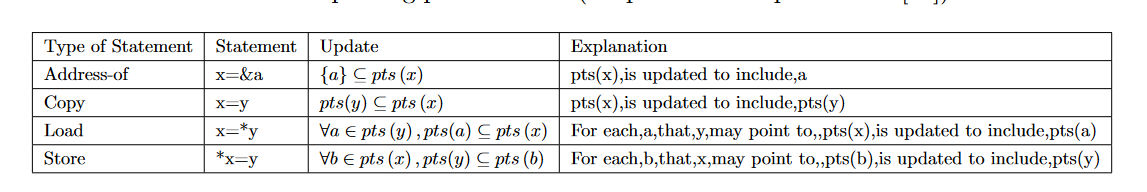
* statement of the form LHS = RHS, adding set-constraint RHS⊆ LHS i.e., the points-to set of RHS is subset of LHS
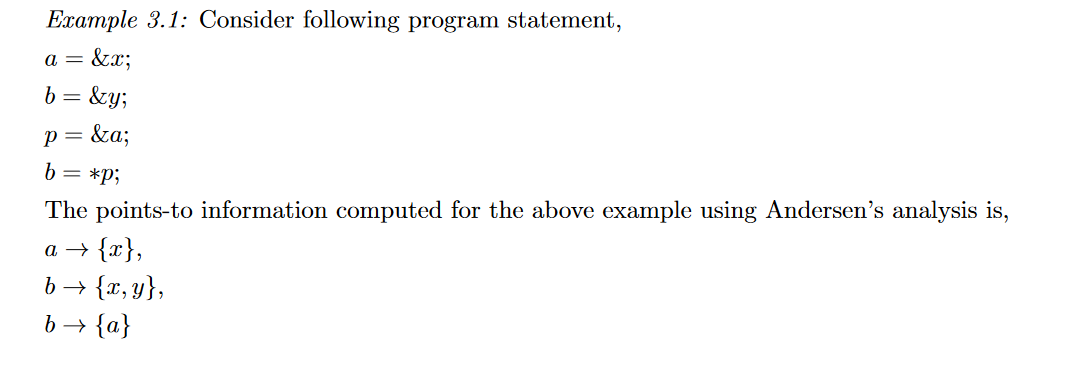